# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

base_dir = "."

training_file = "{}/train.p".format(base_dir)
testing_file = "{}/test.p".format(base_dir)

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print("done")

done


In [2]:
import time
import math

from datetime import timedelta

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split

%matplotlib inline

/Users/prakhar/anaconda3/envs/CarND-TensorFlow-Lab/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# read label to signname mapping
base_dir = "."
label_to_name_map = {}
with open("{}/signnames.csv".format(base_dir), mode='r') as f:
    for line in f:
        parts = line.strip().split(',')
        if parts[0] == 'ClassId':
            continue
        label_to_name_map[int(parts[0])] = parts[1]

In [4]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape[:2]

# TODO: how many classes are in the dataset
class_set = set()
for l in train['labels']:
    class_set.add(l)
n_classes = len(class_set)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


<Container object of 43 artists>

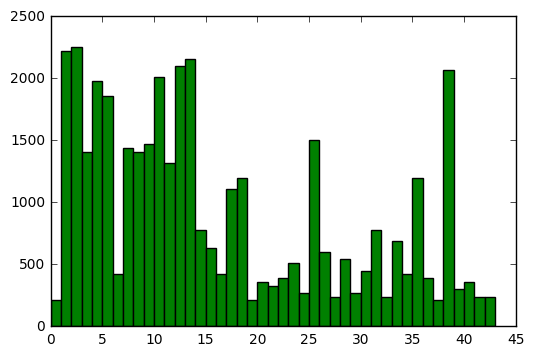

In [5]:
def examples_per_label(labels):
    d = {}
    for l in labels:
        c = d.get(l, 0)
        d[l] = c+1
    return d
d = examples_per_label(train['labels'])
plt.bar(d.keys(), d.values(), 1.0, color='g')

Visualizing training data image at 1000th index
label: Speed limit (30km/h)
size: [63 63]
coordinates: [ 6  5 58 57]


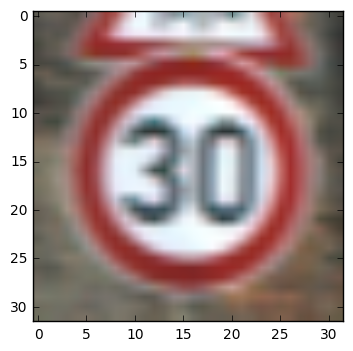

In [6]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
i = 1000
print("Visualizing training data image at {}th index".format(i))
imgplot = plt.imshow(X_train[i])
print("label: {}".format(label_to_name_map[train["labels"][i]]))
print("size: {}".format(train["sizes"][i]))
print("coordinates: {}".format(train["coords"][i]))

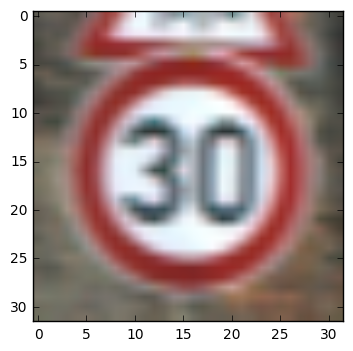

In [7]:
i = 1000
img=X_train[i].flatten().reshape(32, 32, 3)
plt.imshow(img)

In [8]:
# data dimensions

img_size = X_train[0].shape[0]

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size * num_channels

# Tuple with height, width, num_channels of images used to reshape arrays.
img_shape = (img_size, img_size, num_channels)

# Number of classes, one class for each of 10 digits.
num_classes = n_classes

In [9]:
# method to plot images in a 6x6 grid
def plot_images(images, cls_true, cls_pred=None, nrows=6, ncols=6):
    
    fig, axes = plt.subplots(nrows, ncols)
    fig.subplots_adjust(hspace=1., wspace=1.)
    
    for i, ax in enumerate(axes.flat):
        # plot image
        try:
            ax.imshow(images[i].reshape(img_shape), cmap='binary')
        except IndexError:
            break
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


## Plot a few images

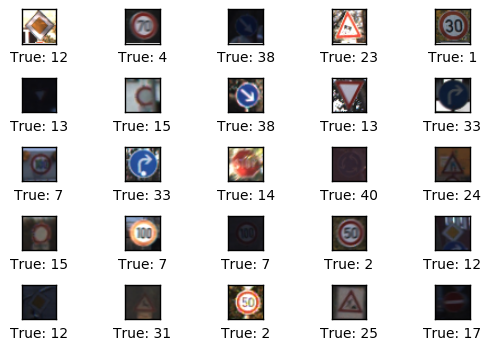

In [10]:
# Get the first images from the test-set.
nrows = 5
ncols = 5
indices_to_plot = np.random.choice(len(X_train), nrows*ncols)
images = [X_train[i] for i in indices_to_plot]
cls_true = [train['labels'][i] for i in indices_to_plot]
plot_images(images=images, cls_true=cls_true, nrows=nrows, ncols=ncols)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# transform image

RESIZE = [{
    'fx': 0.9,
    'fy': 1.1
}]
TRANSLATION = [
    {
        'tx': -2.,
        'ty': 0.
    },
    {
        'tx': 2.,
        'ty': 0.
    },
    {
        'tx': 0.,
        'ty': 2.
    },
    {
        'tx': 0.,
        'ty': -2.
    },
    {
        'tx': -2.,
        'ty': -2.
    },
    {
        'tx': 2.,
        'ty': -2.
    },
    {
        'tx': -2.,
        'ty': 2.
    },
    {
        'tx': 2.,
        'ty': 2.
    }
]
ROTATION = [
    {
        'angle': 15,
        'scale': 1
    }
]
FLAG = cv2.COLOR_BGR2GRAY

def normalize_greyscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

def normalize(im, flag=FLAG, custom_norm=False):
    if flag == cv2.COLOR_BGR2GRAY:
        if custom_norm:
            norm = normalize_greyscale(im)
        else:
            norm = np.copy(im)
            norm = cv2.normalize(im, norm, 0., 1., cv2.NORM_MINMAX, cv2.CV_32F)
        norm = cv2.cvtColor(norm, flag)
        norm = norm.flatten()
    elif flag is None:
        norm = np.copy(im)
        norm = cv2.normalize(im, norm, 0., 1., cv2.NORM_MINMAX, cv2.CV_32F)
        norm = norm.flatten()
    return norm

def translate(im, tx, ty):
    rows, cols = im.shape[0: 2]
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(im, M, (cols, rows))

def rotate(im, angle, scale):
    rows, cols = im.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, scale)
    dst = cv2.warpAffine(im, M, (cols, rows))
    return dst

def resize(im, fx, fy, interpolation=cv2.INTER_LINEAR):
    return cv2.resize(im, None, fx, fy, interpolation)

def transform(im, flag=FLAG):
    images = []
    images.append(normalize(im, flag))
#     for t in TRANSLATION:
#         images.append(normalize(translate(im, t['tx'], t['ty']), flag))

#     for r in ROTATION:
#         for angle in range(1, r['angle']+1):
#             images.append(normalize(rotate(im, angle, r['scale']), flag))
#             images.append(normalize(rotate(im, -1 * angle, r['scale']), flag))

# #     for r in RESIZE:
# #         images.append(normalize(resize(im, r['fx'], r['fy']), flag))
    return images


In [12]:
i = 0
im = X_train[i]
images = transform(im, flag=None)
print(len(images))

1


### Question 1 

Training and test dataset are combined to form a single dataset. For each image in the dataset
For each image in the dataset (training + test) we generate 6 additional images as follows: -

1. Translate 2 pixels left
1. Translate 2 pixels right
1. Translate 2 pixels top
1. Translate 2 pixels bottom
1. Rotation by 15 degrees (clockwise)
1. Rotation by -15 degrees (anti-clockwise)

This gives us a dataset 4 times the size of the initial dataset (training + test). Each image in the new dataset is normalized as per `cv2.normalize` and converted to grayscale. The dataset is then split into training, validation and test samples as per a 60, 20, 20 distribution.

**Answer:**

In [66]:
# Generate data additional (if you want to!)

def one_hot_encode(y, num_examples, num_classes):
    ret_y = np.zeros((num_examples, num_classes))
    for r in range(num_examples):
        ret_y[r][y[r]] = 1
    return ret_y

# combine training and test data to create a complete dataset
dataset = []
labels = []

for data in [train, test]:
    for idx, img in enumerate(data['features']):
        label = train['labels'][idx]
        tmp_dataset = transform(img, flag=None)
        tmp_labels = [label for x in range(len(tmp_dataset))]
        dataset.extend(tmp_dataset)
        labels.extend(tmp_labels)

labels = one_hot_encode(labels, len(labels), n_classes)

# convert python list to numpy array
dataset = np.asarray(dataset)
labels = np.asarray(labels)

print("len(dataset): {}, len(labels): {}".format(len(dataset), len(labels)))

len(dataset): 51839, len(labels): 51839


In [124]:
# split dataset into training, validation and test set

# achieve a 70%, 15%, 15% split between training, validaiton and test samples
x_train, x_val, y_train, y_val = train_test_split(dataset, labels, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5)

print("training set size: {}".format(len(x_train)))
print("validation set size: {}".format(len(x_val)))
print("test set size: {}".format(len(x_test)))

training set size: 36287
validation set size: 7776
test set size: 7776


In [125]:
y_val_cls = np.argmax(y_val, axis=1)

In [126]:
y_test_cls = np.argmax(y_test, axis=1)
y_test[0:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [

In [127]:
y_test_cls[0:5]

array([33, 36,  2, 12,  5])

In [70]:
# Helper-functions for creating new variables

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [71]:
# Helper-function for creating a new Convolutional Layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [72]:
# Helper-function for flattening a layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [73]:
# Helper-function for creating a new Fully-Connected Layer
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Configuration of Neural Network

In [74]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## Creating tensorflow computation graph

### Placeholder variables

In [75]:
# placeholder variable for the input images
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

# placeholder variable for the input to convolutional layer. Note that conv layer expect input to be a
# encoded as a 4-dim tensor of shape [num_images, img_height, img_width, num_channels]
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# placeholder variable for one-hot-encoded true labels associated with input images
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

# variable for class number of the true class
y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional Layer 1
Create the first convolutional layer. It takes x_image as input and creates num_filters1 different filters, each having width and height equal to filter_size1. Finally we wish to down-sample the image so it is half the size by using 2x2 max-pooling.

In [76]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [77]:
layer_conv1

<tf.Tensor 'Relu_3:0' shape=(?, 16, 16, 16) dtype=float32>

### Convolutional Layer 2
Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer.

In [78]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [79]:
layer_conv2

<tf.Tensor 'Relu_4:0' shape=(?, 8, 8, 36) dtype=float32>

### Flatten Layer
The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [80]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [81]:
layer_flat

<tf.Tensor 'Reshape_6:0' shape=(?, 2304) dtype=float32>

In [82]:
num_features

2304

### Fully-Connected Layer 1
Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [83]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [84]:
layer_fc1

<tf.Tensor 'Relu_5:0' shape=(?, 128) dtype=float32>

### Fully-Connected Layer 2
Add another fully-connected layer that outputs vectors of length 43 for determining which of the 43 classes the input image belongs to. Note that ReLU is not used in this layer.

In [85]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [86]:
layer_fc2

<tf.Tensor 'add_7:0' shape=(?, 43) dtype=float32>

### Predicted Class

In [87]:
y_pred = tf.nn.softmax(layer_fc2)

In [88]:
y_pred

<tf.Tensor 'Softmax_1:0' shape=(?, 43) dtype=float32>

In [89]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [90]:
y_pred_cls

<tf.Tensor 'ArgMax_3:0' shape=(?,) dtype=int64>

### Cost-function to be optimized

In [91]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [92]:
cross_entropy

<tf.Tensor 'Reshape_9:0' shape=(?,) dtype=float32>

In [93]:
cost = tf.reduce_mean(cross_entropy)

In [94]:
cost

<tf.Tensor 'Mean_2:0' shape=() dtype=float32>

### Optimization Method

In [95]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [96]:
optimizer

### Performance Measures

In [97]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [98]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Helper function to a random batch of data

In [99]:
def next_random_batch(x, y, batch_size):
    assert len(x) == len(y)
    indices = np.random.choice(len(x), batch_size)
    x_ret = [x[i] for i in indices]
    y_ret = [y[i] for i in indices]
    return x_ret, y_ret

## Helper-function to perform optimization iterations

In [146]:
# Split the test-set into smaller batches of this size.

def print_test_accuracy(session,
                        show_example_errors=False,
                        show_confusion_matrix=False,
                        test_batch_size=256,
                        test_data=True):

    # Number of images in the test-set.
    if test_data:
        num_test = len(y_test)
    else:
        num_test = len(y_val)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        if test_data:
            images = x_test[i:j]

            # Get the associated labels.
            labels = y_test[i:j]
        else:
            images = x_val[i:j]
            labels = y_val[i:j]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    if test_data:
        cls_true = y_test_cls
    else:
        cls_true = y_val_cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / float(num_test)

    # Print the accuracy.
    if test_data:
        msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    else:
        msg = "Accuracy on Validation-Set: {0:.1%} ({1} / {2})"

    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [147]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations,
             session,
             optimizer,
             accuracy,
             train_batch_size=64):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = next_random_batch(x_train, y_train, train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            # Print it.
            print(msg.format(i + 1, acc))
            
            # Calculate the accuracy on the validation-set.
            print_test_accuracy(session, test_data=False)

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

## Helper-function to plot example errors

In [148]:
def plot_example_errors(cls_pred, correct, nrows=3, ncols=3):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = x_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = y_test_cls[incorrect]
    
    # Plot first few images.
    num_items = nrows*ncols
    plot_images(images=images[0:num_items-1],
                cls_true=cls_true[0:num_items-1],
                cls_pred=cls_pred[0:num_items-1],
                nrows=nrows,
                ncols=ncols)

## Helper-function to plot confusion matrix

In [149]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = y_test_cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper function to calculate performance on test or validation set

## Helper-function for showing the performance
Function for printing the classification accuracy on the test-set.
It takes a while to compute the classification for all the images in the test-set, that's why the results are re-used by calling the above functions directly from this function, so the classifications don't have to be recalculated by each function.
Note that this function can use a lot of computer memory, which is why the test-set is split into smaller batches. If you have little RAM in your computer and it crashes, then you can try and lower the batch-size.

## Tensorflow run

### create tensorflow session

In [106]:
session = tf.Session()

### initialize all the variables

In [107]:
session.run(tf.initialize_all_variables())

### Performance before any optimization
The accuracy on the test-set is very low because the model variables have only been initialized and not optimized at all, so it just classifies the images randomly.

In [108]:
print_test_accuracy(session)

Accuracy on Test-Set: 1.6% (125 / 7776)


### Performance after 1 optimization iteration
The classification accuracy does not improve much from just 1 optimization iteration, because the learning-rate for the optimizer is set very low.

In [109]:
optimize(1, session, optimizer, accuracy)

Optimization Iteration:      1, Training Accuracy:   4.7%
Time usage: 0:00:00


In [110]:
print_test_accuracy(session)

Accuracy on Test-Set: 2.6% (202 / 7776)


### Performance after 100 optimization iterations
After 100 optimization iterations, the model has significantly improved its classification accuracy.

In [111]:
optimize(99, session, optimizer, accuracy) # we already did 1 iteration earlier

Time usage: 0:00:08


Accuracy on Test-Set: 48.9% (3804 / 7776)
Example errors:


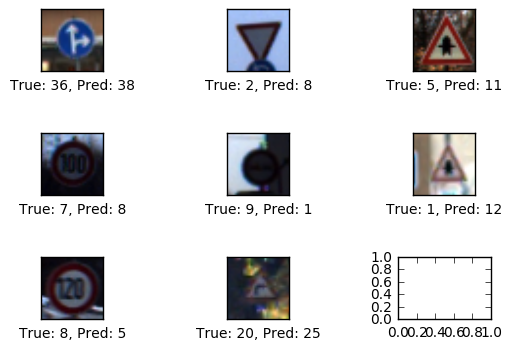

In [135]:
print_test_accuracy(session, show_example_errors=True)

### Performance after 1000 optimization iterations
After 1000 optimization iterations, the model has greatly increased its accuracy on the test-set to more than 90%.

In [116]:
optimize(900, session, optimizer, accuracy) # we already did 1 iteration earlier

Optimization Iteration:    101, Training Accuracy:  12.5%
Optimization Iteration:    201, Training Accuracy:  10.9%
Optimization Iteration:    301, Training Accuracy:  14.1%
Optimization Iteration:    401, Training Accuracy:  18.8%
Optimization Iteration:    501, Training Accuracy:  32.8%
Optimization Iteration:    601, Training Accuracy:  37.5%
Optimization Iteration:    701, Training Accuracy:  48.4%
Optimization Iteration:    801, Training Accuracy:  45.3%
Optimization Iteration:    901, Training Accuracy:  51.6%
Time usage: 0:01:19


Accuracy on Test-Set: 48.9% (3804 / 7776)
Example errors:


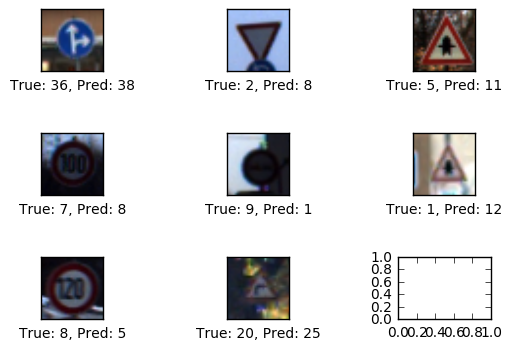

In [142]:
print_test_accuracy(session, show_example_errors=True)

In [150]:
optimize(100, session, optimizer, accuracy)

Optimization Iteration:      1, Training Accuracy:  51.6%
Accuracy on Validation-Set: 47.9% (3728 / 7776)
Time usage: 0:00:12


In [151]:
optimize(1000, session, optimizer, accuracy)

Optimization Iteration:    101, Training Accuracy:  46.9%
Accuracy on Validation-Set: 48.7% (3785 / 7776)
Optimization Iteration:    201, Training Accuracy:  51.6%
Accuracy on Validation-Set: 53.0% (4121 / 7776)
Optimization Iteration:    301, Training Accuracy:  46.9%
Accuracy on Validation-Set: 54.0% (4197 / 7776)
Optimization Iteration:    401, Training Accuracy:  50.0%
Accuracy on Validation-Set: 54.5% (4236 / 7776)
Optimization Iteration:    501, Training Accuracy:  60.9%
Accuracy on Validation-Set: 54.5% (4235 / 7776)
Optimization Iteration:    601, Training Accuracy:  62.5%
Accuracy on Validation-Set: 56.2% (4374 / 7776)
Optimization Iteration:    701, Training Accuracy:  50.0%
Accuracy on Validation-Set: 58.4% (4538 / 7776)
Optimization Iteration:    801, Training Accuracy:  53.1%
Accuracy on Validation-Set: 59.3% (4615 / 7776)
Optimization Iteration:    901, Training Accuracy:  62.5%
Accuracy on Validation-Set: 59.4% (4618 / 7776)
Optimization Iteration:   1001, Training Accur

Accuracy on Test-Set: 60.9% (4736 / 7776)
Example errors:


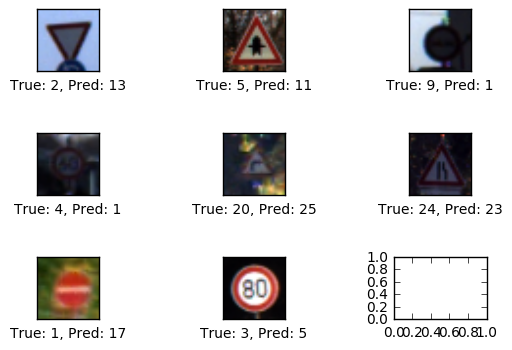

In [152]:
print_test_accuracy(session, show_example_errors=True)

In [153]:
optimize(10000, session, optimizer, accuracy)

Optimization Iteration:   1101, Training Accuracy:  62.5%
Accuracy on Validation-Set: 61.1% (4749 / 7776)
Optimization Iteration:   1201, Training Accuracy:  71.9%
Accuracy on Validation-Set: 62.2% (4839 / 7776)
Optimization Iteration:   1301, Training Accuracy:  60.9%
Accuracy on Validation-Set: 61.1% (4753 / 7776)
Optimization Iteration:   1401, Training Accuracy:  62.5%
Accuracy on Validation-Set: 63.4% (4931 / 7776)
Optimization Iteration:   1501, Training Accuracy:  68.8%
Accuracy on Validation-Set: 63.5% (4937 / 7776)
Optimization Iteration:   1601, Training Accuracy:  73.4%
Accuracy on Validation-Set: 64.6% (5025 / 7776)
Optimization Iteration:   1701, Training Accuracy:  64.1%
Accuracy on Validation-Set: 63.6% (4948 / 7776)
Optimization Iteration:   1801, Training Accuracy:  64.1%
Accuracy on Validation-Set: 64.6% (5024 / 7776)
Optimization Iteration:   1901, Training Accuracy:  65.6%
Accuracy on Validation-Set: 64.7% (5034 / 7776)
Optimization Iteration:   2001, Training Accur

Accuracy on Test-Set: 72.7% (5657 / 7776)
Example errors:


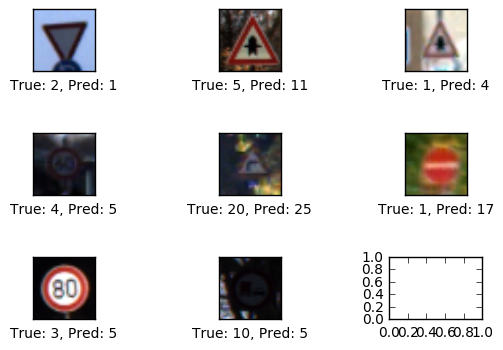

In [154]:
print_test_accuracy(session, show_example_errors=True)

In [155]:
optimize(10000, session, optimizer, accuracy)

Optimization Iteration:  11101, Training Accuracy:  79.7%
Accuracy on Validation-Set: 73.3% (5698 / 7776)
Optimization Iteration:  11201, Training Accuracy:  78.1%
Accuracy on Validation-Set: 72.9% (5665 / 7776)
Optimization Iteration:  11301, Training Accuracy:  79.7%
Accuracy on Validation-Set: 73.6% (5724 / 7776)
Optimization Iteration:  11401, Training Accuracy:  78.1%
Accuracy on Validation-Set: 72.6% (5645 / 7776)
Optimization Iteration:  11501, Training Accuracy:  75.0%
Accuracy on Validation-Set: 73.5% (5715 / 7776)
Optimization Iteration:  11601, Training Accuracy:  73.4%
Accuracy on Validation-Set: 73.9% (5746 / 7776)
Optimization Iteration:  11701, Training Accuracy:  84.4%
Accuracy on Validation-Set: 73.9% (5744 / 7776)
Optimization Iteration:  11801, Training Accuracy:  82.8%
Accuracy on Validation-Set: 73.4% (5707 / 7776)
Optimization Iteration:  11901, Training Accuracy:  78.1%
Accuracy on Validation-Set: 72.8% (5664 / 7776)
Optimization Iteration:  12001, Training Accur

Accuracy on Test-Set: 74.0% (5751 / 7776)
Example errors:


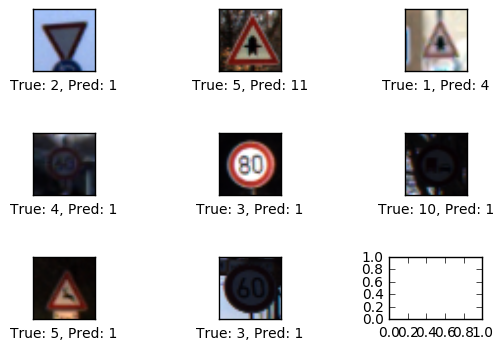

In [156]:
print_test_accuracy(session, show_example_errors=True)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.